## Reconhecimento Facial com Metric Learning e Máscaras Faciais

### Introdução
O reconhecimento facial é um dos desafios mais importantes no campo do Machine Learning. Inicialmente, os modelos eram treinados como classificadores, onde cada pessoa era tratada como uma classe única. No entanto, essa abordagem tinha uma grande limitação: sempre que uma nova pessoa era adicionada ao banco de dados, o modelo precisava ser re-treinado, tornando a escalabilidade do sistema inviável.

Para contornar esse problema, surgiu o **Aprendizado de Métrica** (*Metric Learning*), uma abordagem que permite que o modelo aprenda uma métrica de similaridade entre faces. Em vez de classificar indivíduos diretamente, o modelo gera vetores descritivos (*embeddings*) que representam as características únicas de cada face. Esse método permite a inclusão de novas pessoas no banco de dados sem a necessidade de re-treinamento do modelo.

No entanto, com a pandemia da COVID-19, o uso de máscaras faciais afetou significativamente os sistemas de reconhecimento facial, pois cobrem parte das características essenciais utilizadas pelos modelos para gerar os vetores descritivos. Dessa forma, novas soluções precisaram ser desenvolvidas para melhorar a precisão do reconhecimento facial em indivíduos que usam máscaras.

### Objetivo da Tarefa
Nesta atividade, vamos abordar esse problema seguindo os seguintes passos:

1. **Treinar um modelo de rede neural** utilizando um conjunto de dados com imagens de diversas celebridades.
2. **Criar um banco de dados** contendo os vetores descritivos (*embeddings*) gerados pelo modelo para cada celebridade.
3. **Incluir uma nova pessoa no banco de dados**, extraindo o vetor descritivo de sua imagem.
4. **Realizar o reconhecimento facial** dessa pessoa enquanto ela estiver usando uma máscara, verificando se o modelo é capaz de identificá-la corretamente.

Com essa abordagem, exploraremos os desafios do reconhecimento facial em cenários reais e a importância do *Metric Learning* para criar sistemas mais flexíveis e escaláveis.


# Instalando dependências

In [113]:
!pip install wordcloud matplotlib nltk

In [114]:
!pip install torch

  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.


In [115]:
!pip install torchvision

In [116]:
!pip install tensorflow

  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.34 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
mypy 1.11.2 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
torch 2.4.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.


In [117]:
!pip install tensorflow_hub

# Importando bibliotecas



In [118]:
import os

#descompactação
import zipfile

# manipulação de dados
import pandas as pd
import json

# gráficos
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
import matplotlib.image as mpimg

# machine learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import numpy as np
import random
import tensorflow_hub as hub

# avaliação
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score

# utils
import requests
from tqdm import tqdm
from scipy.spatial.distance import cosine

# processamento de linguagem natural
import nltk
from collections import Counter
import re
from nltk.util import ngrams

#downloads
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\erica\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Descompactando dados

In [119]:
folder_path = 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/post-processed.zip'
extract_path = 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/'


In [120]:
# Extrair o conteúdo do ZIP para uma nova pasta
with zipfile.ZipFile(folder_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Arquivos extraídos para:", extract_path)

Arquivos extraídos para: C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/


A extração possibilita o acesso e manipulação da base de dados de imagens, que já estão processadas

In [121]:
dataset_path = extract_path+'post-processed'

# Visualizando estrutura dos dados

In [122]:
# Listar todas as pastas dentro da pasta "dataset"
all_folders = os.listdir(dataset_path)
print("10 exemplos de conteúdos da pasta:", all_folders[:10])

10 exemplos de conteúdos da pasta: ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah']


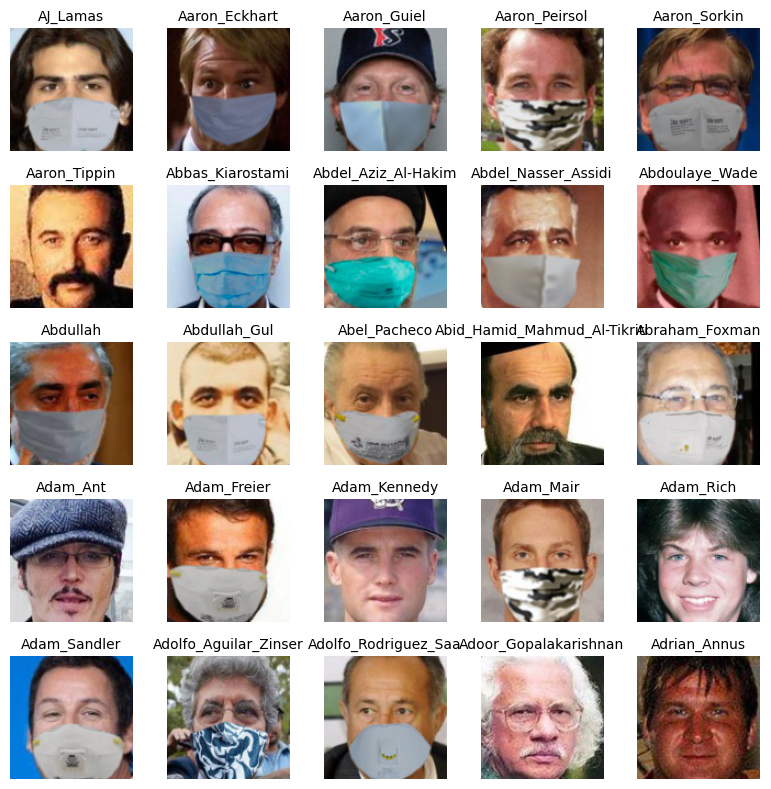

In [123]:
# Listar as primeiras 25 pastas (nomes dos famosos)
celebrity_folders = sorted(os.listdir(dataset_path))[:25]

# Criar uma figura 8x8 com subplots de 5x5
fig, axes = plt.subplots(5, 5, figsize=(8, 8))

# Iterar sobre as primeiras 25 pastas
for idx, folder in enumerate(celebrity_folders):
    folder_path = os.path.join(dataset_path, folder)

    # Listar imagens na pasta e selecionar uma aleatória
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    image_path = os.path.join(folder_path, random.choice(image_files))  # Escolhe uma imagem aleatória da pasta
    
    # Carregar imagem com PIL
    img = Image.open(image_path)  # Mantém a imagem no formato original
    
    # Plotar a imagem na grid
    row, col = divmod(idx, 5)  # Calcula a linha e a coluna
    axes[row, col].imshow(img)  # PIL já carrega no formato correto
    axes[row, col].axis("off")  # Remove eixos
    axes[row, col].set_title(folder, fontsize=10)  # Define o título como o nome da pasta (celebridade)

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

# Carregar imagens e rótulos

In [124]:
# Criando uma lista com o nome de todos as celebridades (serão os rótulos)
labels = [fname for fname in os.listdir(dataset_path)]
print(labels[:30])

['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Peirsol', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdullah', 'Abdullah_Gul', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abraham_Foxman', 'Adam_Ant', 'Adam_Freier', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_Murrell', 'Adrian_Nastase', 'Adrien_Brody', 'Afton_Smith', 'Agnelo_Queiroz']


In [125]:
# Função para listar todas as pastas recursivamente
def listar_subpastas(path):
    subfolders = []
    for root, dirs, files in os.walk(path):  # Walk percorre a estrutura de pastas
        for dir_name in dirs:
            subfolders.append(os.path.join(root, dir_name))  # Adiciona o caminho completo da subpasta
    return subfolders

# Chamar a função para listar as subpastas
folders = listar_subpastas(dataset_path)


In [126]:
print(folders[:10])

['C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Eckhart', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Guiel', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Peirsol', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Sorkin', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Tippin', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Abbas_Kiarostami', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Abdel_Aziz_Al-Hakim', 'C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-proce

In [127]:
print(str(len(folders)) + ' , ' + str(len(labels)))

2996 , 2996


In [128]:
# Criando o dataframe
dataset = datasets.ImageFolder(root=dataset_path)

In [129]:
print(dataset.samples[:5])  # Exibe os primeiros 5 exemplos

[('C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\AJ_Lamas\\AJ_Lamas_0001_0000.jpg', 0), ('C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\AJ_Lamas\\AJ_Lamas_0002_0000.jpg', 0), ('C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Eckhart\\Aaron_Eckhart_0001_0000.jpg', 1), ('C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Eckhart\\Aaron_Eckhart_0001_0001.jpg', 1), ('C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed\\Aaron_Eckhart\\Aaron_Eckhart_0001_0002.jpg', 1)]


In [130]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 12000
    Root location: C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/post-processed


In [131]:
print("Total de imagens carregadas:", len(dataset))

Total de imagens carregadas: 12000


In [132]:
# Criar dicionário {classe: lista de índices}
label_to_idx = {}
for idx, (_, label) in enumerate(dataset.samples):
    if label not in label_to_idx:
        label_to_idx[label] = []
    label_to_idx[label].append(idx)

In [133]:
print(list(label_to_idx.items())[:10])

[(0, [0, 1]), (1, [2, 3, 4, 5, 6, 7]), (2, [8, 9]), (3, [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]), (4, [22, 23, 24, 25]), (5, [26, 27]), (6, [28, 29]), (7, [30, 31]), (8, [32, 33]), (9, [34, 35, 36, 37, 38])]


In [134]:
# Converter listas para arrays NumPy (mais rápido para buscas aleatórias)
for label in label_to_idx:
    label_to_idx[label] = np.array(label_to_idx[label])

# Carregar rede neural pré-treinada

In [135]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## resnet18

In [ ]:
# Carregar modelo pré-treinado
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 128)  # Modificando a última camada para gerar embeddings de 128 dimensões

In [ ]:
resnet = resnet.to(device)

## mobilenet

In [136]:
# Usando mobilenet para tentar diminuir tempo de processamento
mobilenet = models.mobilenet_v2(pretrained=True)  # Carregar modelo pré-treinado
num_ftrs = mobilenet.classifier[1].in_features  # Obter número de features da última camada
mobilenet.classifier[1] = nn.Linear(num_ftrs, 128)  # Substituir por uma camada de saída com 128 dimensões

In [137]:
mobilenet = mobilenet.to(device)

# Triplet Loss

In [138]:
# Função Triplet Loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_dist = F.pairwise_distance(anchor, positive, p=2)
    neg_dist = F.pairwise_distance(anchor, negative, p=2)
    loss = torch.relu(pos_dist - neg_dist + margin)
    return loss.mean()

In [139]:
# Gerar triplas
triplets = []
for anchor_idx, (_, anchor_label) in enumerate(dataset.samples):
    # Selecionar positivo (mesma classe da âncora)
    if anchor_label not in label_to_idx:
        continue  # Pula caso o rótulo não esteja no dicionário

    pos_indices = label_to_idx[anchor_label]
    if len(pos_indices) < 2:
        continue  # Pula classes que não têm pelo menos 2 exemplos

    pos_idx = np.random.choice(pos_indices)
    while pos_idx == anchor_idx:
        pos_idx = np.random.choice(pos_indices)

    # Selecionar negativo (classe diferente da âncora)
    neg_labels = list(set(label_to_idx.keys()) - {anchor_label})
    neg_label = random.choice(neg_labels)
    neg_idx = np.random.choice(label_to_idx[neg_label])

    # Adicionar tripla à lista
    triplets.append((anchor_idx, pos_idx, neg_idx))

# Mostrar estatísticas
print(f"Total de triplas geradas: {len(triplets)}")

Total de triplas geradas: 11988


# Treinando Rede Neural

In [140]:
# Transformando as imagens
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),
])

In [144]:
# Defina a transformação para converter as imagens PIL para tensores
transform = transforms.ToTensor()

# Função para buscar as imagens com base nos índices e criar triplets
def collate_fn(batch):
    anchors, positives, negatives = [], [], []
    for anchor_idx, pos_idx, neg_idx in batch:
        # Carregar as imagens reais a partir dos índices
        anchor_img, _ = dataset[anchor_idx]
        positive_img, _ = dataset[pos_idx]
        negative_img, _ = dataset[neg_idx]
        
        # Transformar as imagens para tensores
        anchor_img = transform(anchor_img)
        positive_img = transform(positive_img)
        negative_img = transform(negative_img)
        
        # Adicionar as imagens às listas
        anchors.append(anchor_img)
        positives.append(positive_img)
        negatives.append(negative_img)
    
    # Retornar as imagens empacotadas em tensores
    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

In [145]:
# Criar o DataLoader
dataloader = DataLoader(
    triplets,  # Passa a lista de triplas
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn  # Função personalizada para agrupar as triplas
)

In [146]:
# Lista para armazenar os embeddings e os rótulos
embeddings_data_base = []
labels_data_base = []

# Definir a TripletMarginLoss
triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)

# Definir o otimizador (pode ser o Adam ou outro)
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

# Colocar o modelo em modo de treinamento
mobilenet.train()

# Número de épocas
num_epochs = 3

# Loop de treinamento
for epoch in range(num_epochs):
    running_loss = 0.0
    
    # Iterando sobre o DataLoader (as triplas)
    for anchor, positive, negative in dataloader:
        # Mover as imagens para o dispositivo (GPU ou CPU)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        # Passar as imagens pela rede para obter os embeddings
        anchor_embedding = mobilenet(anchor)
        positive_embedding = mobilenet(positive)
        negative_embedding = mobilenet(negative)
        
        # Armazenar os embeddings (e os rótulos)
        embeddings_data_base.append(anchor_embedding)
        embeddings_data_base.append(positive_embedding)
        embeddings_data_base.append(negative_embedding)

        # Armazenar rótulos (caso queira fazer uma predição mais tarde)
        labels_data_base.append(anchor_label)  
        labels_data_base.append(anchor_label)  
        labels_data_base.append(neg_label)     

        # Calcular a perda
        loss = triplet_loss(anchor_embedding, positive_embedding, negative_embedding)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Registrar a perda
        running_loss += loss.item()

    # Exibir a perda média por época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")

print("Treinamento concluído!")

Epoch [1/3], Loss: 0.6047929494778316
Epoch [2/3], Loss: 0.45397044813632964
Epoch [3/3], Loss: 0.5198485417664052
Treinamento concluído!


Treinamento concluído em uma hora

# predizendo nova pessoa v final

In [150]:
# Função para gerar o embedding
def generate_embedding(image_path, model, transform):
    # Carregar a imagem
    image = Image.open(image_path).convert('RGB')
    
    # Aplicar a transformação
    image = transform(image).unsqueeze(0)  # Adiciona uma dimensão extra para o batch
    
    # Mover para o dispositivo (GPU ou CPU)
    image = image.to(device)
    
    # Passar pela rede para obter o embedding
    with torch.no_grad():  # Desabilitar gradientes para não realizar backpropagation
        embedding = model(image)
    
    return embedding

In [151]:
# Caminho da nova imagem sem máscara
new_image_without_mask_path = "C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/new_entries/Eric_Anderson/eric_sem_mascara.jpg"


# 1. Gerar o embedding para a nova imagem sem máscara
new_embedding_without_mask = generate_embedding(new_image_without_mask_path, mobilenet, transform)

In [152]:
# Adicionar à base de dados de embeddings
embeddings_data_base.append(new_embedding_without_mask)
labels_data_base.append(dataset[-1][1] + 1)  # Adicionar o novo rótulo

print(f"Novo embedding gerado e adicionado. Total de embeddings agora: {len(embeddings_data_base)}")


Novo embedding gerado e adicionado. Total de embeddings agora: 6751


In [ ]:
# Função para verificar as dimensões dos embeddings na base de dados
def check_embeddings_dimensions(embeddings_data_base):
    # Contador para embeddings com dimensões diferentes de 2048
    embeddings_with_diff_dim = 0
    embeddings_with_2048_dim = 0
    
    # Lista para armazenar as dimensões dos embeddings que não possuem 2048 dimensões
    diff_dim_embeddings = []
    
    for embedding in embeddings_data_base:
        # Verifica as dimensões do embedding (deve ser um tensor de 2 dimensões: (1, 2048))
        if embedding.shape[1] == 2048:
            embeddings_with_2048_dim += 1
        else:
            embeddings_with_diff_dim += 1
            # Adiciona as dimensões do embedding que não tem 2048
            diff_dim_embeddings.append(embedding.shape)
    
    # Exibe a quantidade de embeddings com 2048 dimensões e outros
    print(f"Total de embeddings com 2048 dimensões: {embeddings_with_2048_dim}")
    print(f"Total de embeddings com dimensões diferentes de 2048: {embeddings_with_diff_dim}")
    
    # Se houver embeddings com dimensões diferentes de 2048, imprime as dimensões
    if embeddings_with_diff_dim > 0:
        print(f"Dimensões dos embeddings com valores diferentes de 2048:")
        for dims in diff_dim_embeddings:
            print(dims)
    
    return embeddings_with_2048_dim, embeddings_with_diff_dim

# Chamar a função para verificar as dimensões
check_embeddings_dimensions(embeddings_data_base)

In [153]:
new_image_with_mask_path = "C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/new_entries/test/pessoa_de_mascara.png"

# 2. Gerar o embedding para a nova imagem com máscara
new_embedding_with_mask = generate_embedding(new_image_with_mask_path, mobilenet, transform)

# 3. Calcular a distância entre o embedding da nova imagem com máscara e os embeddings existentes
def predict_person(new_embedding, embeddings_data_base, labels_data_base):
    distances = []
    
    # Calcular a distância euclidiana entre o embedding da nova imagem e os existentes
    for embedding in embeddings_data_base:
        dist = F.pairwise_distance(new_embedding, embedding)
        distances.append(dist.item())
    
    # Encontrar o índice da menor distância
    min_dist_idx = np.argmin(distances)
    
    # Obter o rótulo da pessoa mais próxima
    predicted_label = labels_data_base[min_dist_idx]
    return predicted_label

# 4. Prever a pessoa para a nova imagem com máscara
predicted_person = predict_person(new_embedding_with_mask, embeddings_data_base, labels_data_base)

print(f"A pessoa na nova imagem com máscara é: {predicted_person}")

RuntimeError: a Tensor with 16 elements cannot be converted to Scalar

# Adicionar nova pessoa a base de dados

In [147]:
# Acessar a última tupla e pegar o rótulo
last_label = dataset[-1][1]

print(f"O último rótulo é: {last_label}")

O último rótulo é: 2995


In [148]:
print(dataset[-1][1]+1)

2996


In [46]:
# Função para adicionar um novo embedding à base de dados
def add_embedding(image_without_mask_path, label):
    # Carregar e transformar a imagem sem máscara
    image = Image.open(image_without_mask_path)  # Abre a imagem
    image = transform(image).unsqueeze(0).to(device)  # Aplica transformações e adiciona batch dimension

    # Obter o embedding da nova imagem
    image_embedding = mobilenet(image).detach()  # Desativa gradientes para não afetar o modelo

    # Adicionar o embedding e o rótulo à base de dados
    embeddings_data_base.append(image_embedding)
    labels_data_base.append(label)

    print(f"Nova imagem sem máscara adicionada à base de dados com rótulo: {label}")

# Caminho da nova imagem sem máscara
new_image_without_mask_path = "C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/new_entries/Eric_Anderson/eric_sem_mascara.jpg"

# Rótulo da pessoa (pode ser um número ou nome)
label = dataset[-1][1]+1 # pegando o ultimo rótulo e incrementando um valor

# Adicionar a nova imagem sem máscara à base de dados
add_embedding(new_image_without_mask_path, label)

Nova imagem sem máscara adicionada à base de dados com rótulo: 2996


# Tentando predizer uma pessoa com máscara

In [174]:
def euclidean_distance(embedding1, embedding2):
    # Garantir que os dois embeddings sejam 1D com o mesmo tamanho
    embedding1 = embedding1.view(-1)
    embedding2 = embedding2.view(-1)
    
    # Verificar se os tamanhos dos embeddings são iguais
    if embedding1.size(0) != embedding2.size(0):
        raise ValueError(f"Os embeddings têm tamanhos diferentes: {embedding1.size(0)} vs {embedding2.size(0)}")
    
    return torch.nn.functional.pairwise_distance(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Função de predição
def predict_identity(image_with_mask_path):
    image = Image.open(image_with_mask_path).convert('RGB')  # Garantir que a imagem tenha 3 canais RGB
    image = transform(image).unsqueeze(0).to(device)  # Transformar a imagem e adicionar batch dimension
    
    # Obter o embedding da nova imagem com máscara
    image_embedding = mobilenet(image)
    image_embedding = image_embedding.view(-1)  # Achatar o tensor
    
    min_distance = float('inf')
    predicted_idx = None

    # Comparar o embedding da nova imagem com todos os embeddings armazenados
    for idx, stored_embedding in enumerate(embeddings_data_base):
        stored_embedding = stored_embedding.view(-1)  # Achatar o tensor

        print(image_embedding.shape)
        print(stored_embedding.shape)
        distance = euclidean_distance(image_embedding, stored_embedding).item()
        if distance < min_distance:
            min_distance = distance
            predicted_idx = idx

    # Exibir o índice e a distância do embedding mais próximo
    print(f"A pessoa prevista é a imagem de índice {predicted_idx} com distância {min_distance:.4f}")
    
    # Se você também armazenou os rótulos (labels) das imagens, pode exibir a identidade
    predicted_label = labels_data_base[predicted_idx]
    print(f"Identidade: {predicted_label}")

In [176]:
def euclidean_distance(embedding1, embedding2):
    # Garantir que os dois embeddings sejam 1D com o mesmo tamanho
    embedding1 = embedding1.view(-1)
    embedding2 = embedding2.view(-1)
    
    # Verificar se os tamanhos dos embeddings são iguais
    if embedding1.size(0) != embedding2.size(0):
        raise ValueError(f"Os embeddings têm tamanhos diferentes: {embedding1.size(0)} vs {embedding2.size(0)}")
    
    return torch.nn.functional.pairwise_distance(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Função de predição
def predict_identity(image_with_mask_path):
    image = Image.open(image_with_mask_path).convert('RGB')  # Garantir que a imagem tenha 3 canais RGB
    image = transform(image).unsqueeze(0).to(device)  # Transformar a imagem e adicionar batch dimension
    
    # Obter o embedding da nova imagem com máscara
    image_embedding = mobilenet(image)
    image_embedding = image_embedding.view(-1)  # Achatar o tensor
    
    min_distance = float('inf')
    predicted_idx = None

    # Comparar o embedding da nova imagem com todos os embeddings armazenados
    for idx, stored_embedding in enumerate(embeddings_data_base):
        # Acessar o primeiro embedding do batch, por exemplo, o primeiro da lista
        for i in range(stored_embedding.size(0)):
            single_stored_embedding = stored_embedding[i].view(-1)  # Pega o embedding de uma imagem específica

            print(f"Comparando {image_embedding.shape} com {single_stored_embedding.shape}")
            distance = euclidean_distance(image_embedding, single_stored_embedding).item()
            if distance < min_distance:
                min_distance = distance
                predicted_idx = idx

    # Exibir o índice e a distância do embedding mais próximo
    print(f"A pessoa prevista é a imagem de índice {predicted_idx} com distância {min_distance:.4f}")
    
    # Se você também armazenou os rótulos (labels) das imagens, pode exibir a identidade
    predicted_label = labels_data_base[predicted_idx]
    print(f"Identidade: {predicted_label}")

In [ ]:
new_image_with_mask_path = "C:/Users/erica/Documents/GitHub/Facial-recognition-for-people-wearing-masks/dataset/extracted/new_entries/test/pessoa_de_mascara.png"

predict_identity(new_image_with_mask_path)

In [171]:
predicted_idx = 2995

In [ ]:
# Função para verificar os rótulos armazenados na base de dados
def check_labels():
    print("Rótulos armazenados na base de dados:")
    for idx, label in enumerate(labels_data_base):
        print(f"Índice {idx}: Rótulo {label}")

# Chamar a função para imprimir os rótulos
check_labels()

Next steps:

*colocar minha foto diretamente na base de dados e utilizar ela com o treino geral, ao invés de inserir depois
*organizar um plot com a foto
* utilizar 9 epochs no minimo para melhorar as predições,